In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ["CUDA_VISIBLE_DEVICES"]="2"    
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import transforms, ToPILImage, ToTensor, RandomCrop, Resize

from source.mfa.mfa import MFA
from source.mfa.mfa_torch import get_latent_posterior_mean, init_raw_parms_from_gmm, get_max_posterior_component, generate_from_posterior
from source.mfa.mfa_utils import plot_figures, from_torch_to_numpy

from source.mfa.celeba_dataset import CelebaDataset, FlattenTransform, TRAIN, VAL

## Approximation of an image by projection it onto a subspace spanned by model components

In [3]:
path_to_fa_model = "/home/konstantin/personal/OnGansAndGMMs/run/e1_fa_256_saved_gmm.pkl"

fa_gmm_model = MFA()
fa_gmm_model.load(path_to_fa_model)

In [4]:
G_PI, G_MU, G_A, G_D = init_raw_parms_from_gmm(fa_gmm_model)

In [5]:
DATASET_ROOT = '/home/konstantin/datasets'
BATCH_SIZE = 25

train_transforms = transforms.Compose([
        ToPILImage(),
        Resize((64, 64)),
        ToTensor(),
        FlattenTransform()
])

train_dataset = CelebaDataset(DATASET_ROOT, TRAIN, train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
X = train_loader.__iter__().__next__().cuda()
X_hat = generate_from_posterior(X, G_PI, G_MU, G_A, G_D)

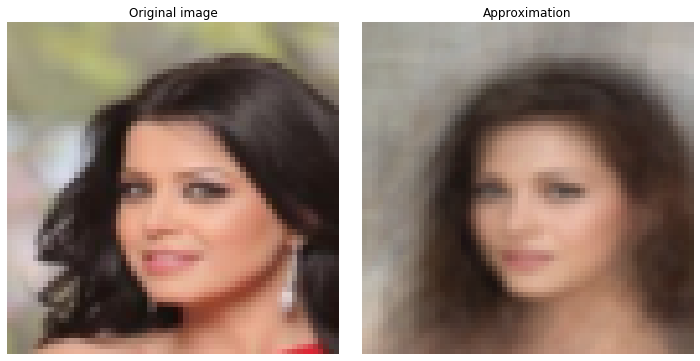

In [17]:
figures = {"Original image": from_torch_to_numpy(X[0].detach().cpu().numpy(), [64, 64])[0],
           "Approximation": from_torch_to_numpy(X_hat[0].detach().cpu().numpy(), [64, 64])[0]}

plot_figures(figures, 1, 2, size=(10, 5))

# Enhancing image sharpness via pix2pix conditional GAN

In [18]:
import torch
from torch.nn.functional import interpolate, upsample
from source.pix2pix.pix2pix import Pix2PixGen

In [19]:
pix2pix_G_path = "/home/konstantin/personal/OnGansAndGMMs/run/e1_pix2pix_gen_1"

pix2pix_G = Pix2PixGen().cuda()
pix2pix_G.load_state_dict(torch.load(pix2pix_G_path))

<All keys matched successfully>

In [20]:
X_sharp = interpolate(pix2pix_G(interpolate(X_hat.view(-1, 3, 64, 64), size=256)), size=64)

/home/konstantin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


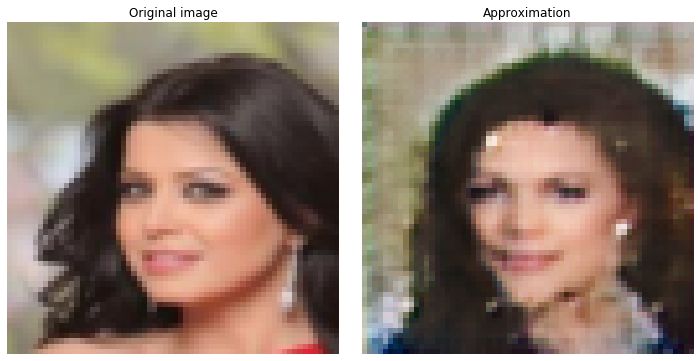

In [21]:
figures = {"Original image": from_torch_to_numpy(X[0].detach().cpu().numpy(), [64, 64])[0],
           "Approximation": from_torch_to_numpy(X_sharp[0].detach().cpu().numpy(), [64, 64])[0]}

plot_figures(figures, 1, 2, size=(10, 5))

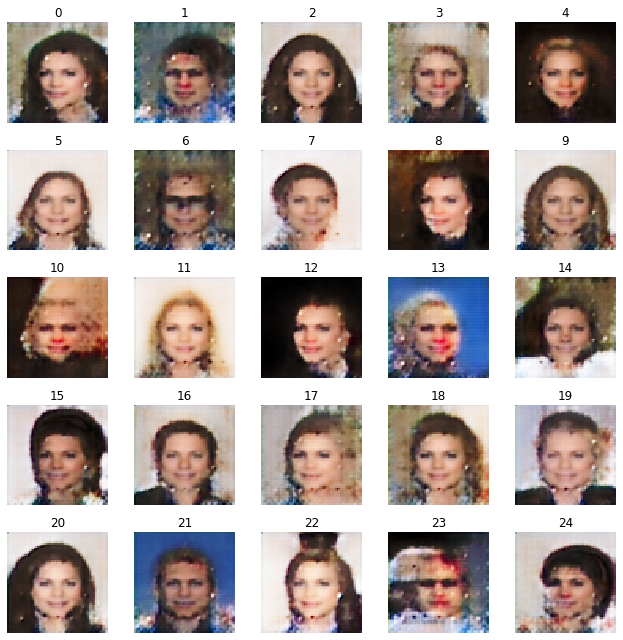

In [22]:
import numpy as np

figures = {}

for i in range(BATCH_SIZE):
    figures[i] = X_sharp[i].detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1)

plot_figures(figures, int(np.sqrt(BATCH_SIZE)), int(np.sqrt(BATCH_SIZE)), (9, 9))